# Defect detection in aluminum castings using EfficientDet

Example using series C0001 of [GDXray](https://domingomery.ing.puc.cl/material/gdxray/). Training and validation using simulated ellipsoidal defects only. Testing on real defects only. Training, Validation and Testing images belong to the same type of wheel. The idea is to demonstrate that we can inspect a type of wheel if we train using the images of this wheel with no defects + simulated defects and test the model on X-ray images of the same type of wheel with real defects.


Based on implementation of 
[how to train EfficientDet](https://towardsdatascience.com/training-efficientdet-object-detection-model-with-a-custom-dataset-25fb0f190555).




# Environment Setup
Download and install in Colab required packages and import libraries.

In [1]:
# Clone Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip

#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX
from IPython.display import Image, clear_output 


Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3747, done.
remote: Total 3747 (delta 0), reused 0 (delta 0), pack-reused 3747
Receiving objects: 100% (3747/3747), 132.20 MiB | 44.43 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Checking out files: 100% (4032/4032), done.
     |████████████████████████████████| 540.1MB 31kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-cp36-none-any.whl size=17452 sha256=37c93c6d075e50dac9a8030438f90e3158f827a2af6a28c5c6e52afeb13838ab
  Stored in directory: /root/.cache/pip/wheels/62/4f/a3/afd4a68f5add45a668c14efa53b64d5cffb2be6bacf993c151
Successfully built dicttoxml
     | 317kB 3.7MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=2f677fe128431053a74f1072d441f59b11e2db7a7f9aa4d3d51d638e7940d764
  Stored in directory: /tmp/pip-ephem-wheel-cache-

# Download casting data

Training, validation and testing images and annotations of series C0001 of GDXray.

In [2]:
# Download training images and annotations
!wget https://www.dropbox.com/s/hjfbghm53oe7uw9/cast.zip


!unzip cast.zip
!rm cast.zip
!mv ./cast/images/test test  
!mv ./cast/images/train train  
!mv ./cast/images/val valid
clear_output()
print('cast.zip unzipped and copied')

#in the next three cells, we move the data into a structure that the image detection library will be expecting
#but no file data manipulation is necessary
#images can also be segmented into class folders, but we combine all classes here
!mkdir Defects
!mkdir Defects/annotations
!mkdir Defects/Annotations
!mkdir Defects/Images

%cp train/_annotations.coco.json Defects/annotations/instances_Images.json

%cp train/*.jpg Defects/Images/

cast.zip unzipped and copied


# Setup training parameters

In [3]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/")
from train_detector import Detector
gtf = Detector()
#directs the model towards file structure
root_dir = "./"
coco_dir = "Defects"
img_dir = "./"
set_dir = "Images"
#smells like some free compute from Colab, nice
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=640, use_gpu=True)
gtf.Model()
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


# Training

EfficientDet model will be trained according to setup.

In [4]:
# Training
output_model = 'trained/'
nb_epochs = 100

%time
gtf.Train(num_epochs=nb_epochs, model_output_dir=output_model);
print('trained model save in directory ' + output_model)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs


Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(inputs) == 2:
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this fu

Buffered data was truncated after reaching the output size limit.

# Detection of Bounding boxes in testing images

In [5]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/")
from infer_detector import Infer
gtf = Infer()
#our trained model weights are in here in onxx format
gtf.Model(model_dir=output_model)
#extract class list from our annotations
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])
class_list

['flaws', 'defect']

## Detection in a random testing image

test/C0001_0033_02.jpg
Done. (0.033s)


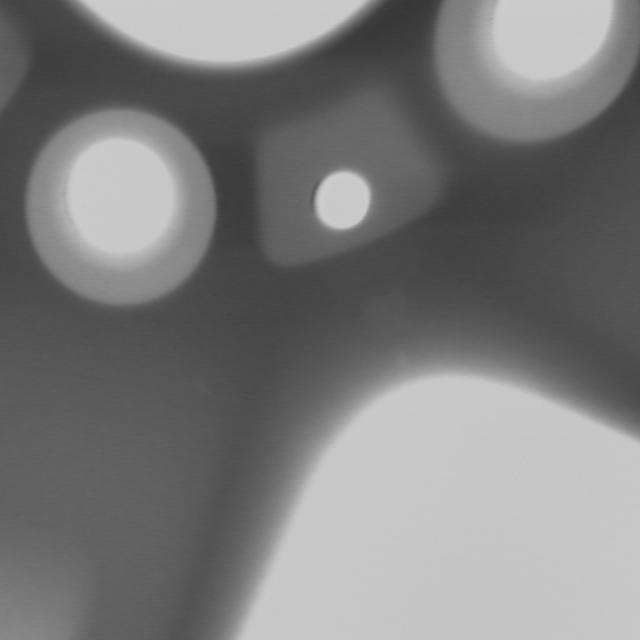

In [6]:
#%%time
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);
print(img_path)
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=1);

Image('output.jpg')


## Detection in all trainsing images

In [7]:
import os, fnmatch,  cv2
import matplotlib.pyplot as plt

def dirfiles(img_path,img_ext):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    if '.DS_Store' in img_names:
        img_names.remove('.DS_Store')
    return img_names

def num2fixstr(x,d):
    st = '%0*d' % (d,x)
    return st

def detection_test_full(img_path,fmt,class_list,th_score,show=0):

    st = '*.'+fmt
    img_names = dirfiles(img_path+'/',st)
    n = len(img_names)
    print('Detecting in ' + str(n) + ' images...')
    fd = open('bbox.csv','w') 
    stn = num2fixstr(n,4)
    color = (255, 0, 0) # blue
    thickness = 2
    for i in range(n):
        img_infer = img_names[i]
        img_st = img_path+'/'+img_infer
        # image = read_image_bgr(img_st)
        image = cv2.imread(img_st)

        # copy to draw on
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)


        print('['+num2fixstr(i,4)+'/'+stn+'] '+img_st)
        duration, scores, labels, boxes = gtf.Predict(img_st, class_list, vis_threshold=th_score);


        for box_id in range(boxes.shape[0]):
          score = float(scores[box_id])
          label = int(labels[box_id])
          box = boxes[box_id, :]

          if score < th_score:
            break


          b = box
          start_point = (b[0], b[1]) 
          end_point = (b[2], b[3]) 
  
          image = cv2.rectangle(draw, start_point, end_point, color, thickness) 
          fd.write(img_st+','+str(b[0])+','+str(b[1])+','+str(b[2])+','+str(b[3])+','+str(score)+'\n') 

        plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.imshow(draw)
        plt.savefig('output/'+img_infer, dpi=300, bbox_inches='tight')
        if show:
          plt.show()
        else:
          plt.clf()
    fd.close()


def detection_test(img_path,fmt,class_list,th_score):

    st = '*.'+fmt
    img_names = dirfiles(img_path+'/',st)
    n = len(img_names)
    print('Detecting in ' + str(n) + ' images...')
    fd = open('bbox.csv','w') 
    stn = num2fixstr(n,4)
    for i in range(n):
        img_infer = img_names[i]
        img_st = img_path+'/'+img_infer

        print('['+num2fixstr(i,4)+'/'+stn+'] '+img_st)
        duration, scores, labels, boxes = gtf.Predict(img_st, class_list, vis_threshold=th_score);


        for box_id in range(boxes.shape[0]):
          score = float(scores[box_id])
          label = int(labels[box_id])
          box = boxes[box_id, :]

          if score < th_score:
            break

          b = box
          fd.write(img_st+','+str(b[0])+','+str(b[1])+','+str(b[2])+','+str(b[3])+','+str(score)+'\n') 

    fd.close()
    print('Test images with bounding boxes stored in folder Inference, bounding boxes and scores are stored in bbox.csv')





In [8]:
# detection in test dataset (bounding boxes are drawn)
detection_test('test','jpg',class_list,0.2)

Detecting in 720 images...
[0000/0720] test/C0001_0001_01.jpg
Done. (0.034s)
[0001/0720] test/C0001_0001_02.jpg
Done. (0.033s)
[0002/0720] test/C0001_0001_03.jpg
Done. (0.032s)
[0003/0720] test/C0001_0001_04.jpg
Done. (0.033s)
[0004/0720] test/C0001_0001_05.jpg
Done. (0.034s)
[0005/0720] test/C0001_0001_06.jpg
Done. (0.035s)
[0006/0720] test/C0001_0001_07.jpg
Done. (0.039s)
[0007/0720] test/C0001_0001_08.jpg
Done. (0.033s)
[0008/0720] test/C0001_0001_09.jpg
Done. (0.034s)
[0009/0720] test/C0001_0001_10.jpg
Done. (0.034s)
[0010/0720] test/C0001_0002_01.jpg
Done. (0.033s)
[0011/0720] test/C0001_0002_02.jpg
Done. (0.034s)
[0012/0720] test/C0001_0002_03.jpg
Done. (0.038s)
[0013/0720] test/C0001_0002_04.jpg
Done. (0.033s)
[0014/0720] test/C0001_0002_05.jpg
Done. (0.037s)
[0015/0720] test/C0001_0002_06.jpg
Done. (0.034s)
[0016/0720] test/C0001_0002_07.jpg
Done. (0.032s)
[0017/0720] test/C0001_0002_08.jpg
Done. (0.033s)
[0018/0720] test/C0001_0002_09.jpg
Done. (0.033s)
[0019/0720] test/C0001_

In [9]:
!zip -r Inference zip Inference/
clear_output()
print('output images zipped in file Inference.zip')


output images zipped in file Inference.zip


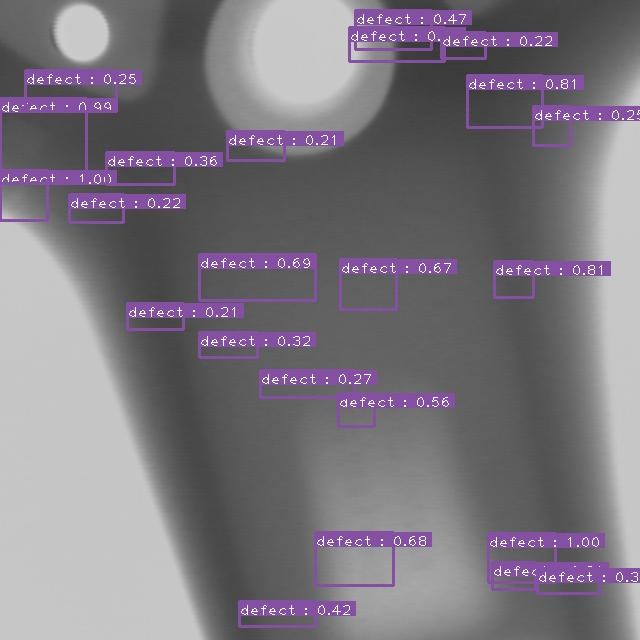

In [10]:
Image(filename='Inference/C0001_0024_03.jpg') 

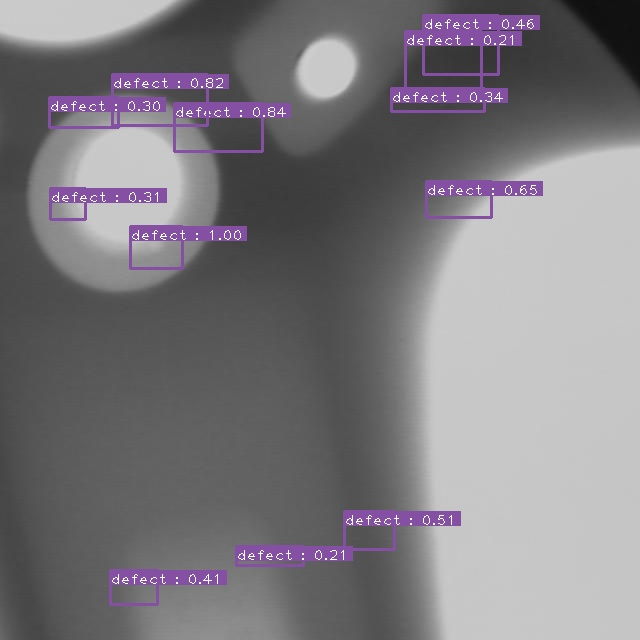

In [11]:
Image(filename='Inference/C0001_0053_05.jpg') 

# Export Trained Weights

In [ ]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%mkdir trained_export
%cp ./trained/signatrix_efficientdet_coco.onnx ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).onnx
%cp ./trained/signatrix_efficientdet_coco.pth ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).pth
%mv ./trained_export/* /content/drive/My\ Drive/

# Reloading Trained Weights after Export

Imagine you have exported your trained model and would like to reaccess it later. This portion of the notebook picks up the trained model and starts at inference


In [ ]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

In [ ]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

In [ ]:
#recover trained weights
!mkdir '/trained'
#note these are old weights that I didn't train for too long
!cp '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.onnx' '/trained/signatrix_efficientdet_coco.onnx'
!cp '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.pth' '/trained/signatrix_efficientdet_coco.pth'

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [ ]:
from infer_detector import Infer
gtf = Infer();

In [ ]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="/trained")

In [ ]:
#download some test data
!curl -L [YOUR LINK HERE] | jar -x

In [ ]:
!ls test

In [ ]:
#extract class list from our annotations
#in your application you will probably already have this saved
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [ ]:
class_list

In [ ]:
%%time
#bang!
img_path = "test/2f6fb003bb89cd401322a535acb42f65_jpg.rf.49b342a7b1f6de3f0e328beaf094a945.jpg";
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

In [ ]:
from IPython.display import Image
Image(filename='output.jpg') 